In [659]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [667]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

# payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# first_table = payload[0]
# second_table = payload[1]

# df = first_table
# df.head()
# my_stocks = df['Symbol'].values.tolist()
# n = len(my_stocks)
# my_stocks.remove('BRK.B')
# my_stocks.remove('BF.B')
# my_stocks.remove('CARR')
# my_stocks.remove('LUMN')
# my_stocks.remove('OTIS')
# my_stocks.remove('VNT')

my_stocks = ['ANSS', 'NDAQ', 'SPY', 'AMZN', 'AAPL', 'MSFT', 'FB', 'GOOG','NFLX','SPOT','SNE',
             'TSLA', 'IBM', 'ADSK', 'MRNA', 'BNTX', 'AMGN','ABBV', 'GILD', 'BIIB', 'EW', 'DHR',
             'WAT', 'BSX', 'DE', 'TM', 'CAT', 'MMM', 'GE', 'BA', 'EADSY', 'MAR', 'WYNN', 'CCL',
             'DAL', 'NEE', 'JPM', 'GS', 'BAC', 'PYPL', 'V', 'FDX', 'SHW', 'ABT', 'EBAY', 'WORK',
             'SNAP', 'PINS', 'TGT', 'TWTR', 'JNJ', 'COLM', 'HD', 'AZN', 'CRM', 'APPN', 
              'NIO', 'REGI', 'CSIQ', 'FTNT', 'PPLT', 'THC', 'CORT', 'HNGR', 'NXGN', 'EOG', 
             'UNH', 'CVS', 'HTH', 'OMF', 'DHT', 'BBY', 'GLD' ]

my_stocks.remove('BNTX')
my_stocks.remove('WORK')
my_stocks.remove('PINS')
my_stocks.remove('SPOT')
my_stocks.remove('MRNA')
my_stocks.remove('NIO')

trade_freq = 2


In [671]:
import urllib.request

print('Downloading data...')

for symbol in my_stocks:
    url2020 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1577836800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    url2019 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1546300800&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'
    url2018 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1514764800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    
    urllib.request.urlretrieve(url2018,symbol+'.csv')
    

## Now read the data using pandas

In [672]:
my_dict = {}
import os
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv(symbol+'.csv')
    os.remove(symbol+'.csv')

n = len(my_dict)
T_all = my_dict['AAPL'].shape[0]

my_dict['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,41.442081,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,41.434864,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.627323,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,42.101261,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.944889,82271200


In [673]:
all_stocks = np.zeros([n,T_all])
for i, symbol in enumerate(my_stocks):
    try:
        all_stocks[i,:] = np.float32(my_dict[symbol].Close)/2 + np.float32(my_dict[symbol].Open)/2
    except:
        print("some problem for data of",symbol)
all_times =  my_dict[symbol].Date

stocks = all_stocks[:,::trade_freq]
times = all_times.iloc[::trade_freq]
T = len(stocks[0])

## Online newton step algorithm and expert

In [674]:
x = np.ones(n)/n
f = np.zeros(T)

# Parameter Free Expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

x_pfe = x
biggest = np.argsort(x)
print('PFE portfolio')
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_pfe[i]*100))+ '%')

PFE portfolio
TSLA	26.84%
SNAP	14.56%
REGI	13.805%
APPN	10.08%
CSIQ	7.01%
THC	3.748%
FTNT	2.336%
CORT	1.945%
PYPL	1.769%
AAPL	1.742%
TGT	1.64%
OMF	1.406%
ADSK	1.311%
EOG	1.173%
NXGN	0.9854%
DHR	0.946%
GE	0.9067%
NFLX	0.7437%
TWTR	0.7373%
AMZN	0.686%
ANSS	0.636%
SNE	0.606%
CCL	0.4958%
DE	0.4766%
FDX	0.4429%
WYNN	0.415%
DAL	0.373%
GS	0.335%
MSFT	0.3115%
EADSY	0.2886%
EW	0.2483%
BIIB	0.1727%
BBY	0.161%
NEE	0.137%
HTH	0.1232%
BAC	0.10474%
COLM	0.0944%
JPM	0.0802%
HD	0.02977%
IBM	0.02968%
ABBV	0.02126%
DHT	0.02118%
CVS	0.01906%
AMGN	0.0%
NDAQ	0.0%
SPY	0.0%
UNH	0.0%
FB	0.0%
GOOG	0.0%
HNGR	0.0%
PPLT	0.0%
CRM	0.0%
AZN	0.0%
MAR	0.0%
V	0.0%
GILD	0.0%
JNJ	0.0%
EBAY	0.0%
WAT	0.0%
BSX	0.0%
ABT	0.0%
TM	0.0%
CAT	0.0%
MMM	0.0%
SHW	0.0%
BA	0.0%
GLD	0.0%


In [675]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [676]:
# ONS
alpha = 0.5
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

x_ons = x

print('ONS portfolio')
biggest = np.argsort(x)
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_ons[i]*100))+ '%')

ONS portfolio
OMF	100.0%
BIIB	4e-07%
DAL	4e-07%
FDX	4e-07%
CCL	4e-07%
PYPL	4e-07%
COLM	4e-07%
GS	4e-07%
AZN	4e-07%
NEE	4e-07%
NFLX	4e-07%
DHT	4e-07%
EADSY	4e-07%
THC	4e-07%
TSLA	4e-07%
CORT	4e-07%
ABBV	4e-07%
DE	4e-07%
AAPL	4e-07%
AMZN	4e-07%
JNJ	4e-07%
ABT	4e-07%
EBAY	4e-07%
NDAQ	4e-07%
AMGN	4e-07%
BBY	4e-07%
PPLT	4e-07%
BSX	4e-07%
JPM	4e-07%
MAR	4e-07%
BA	4e-07%
BAC	4e-07%
ANSS	4e-07%
CAT	4e-07%
TGT	4e-07%
CRM	4e-07%
SPY	3.6e-07%
MMM	3.6e-07%
HNGR	3.6e-07%
EW	3.6e-07%
GOOG	3.6e-07%
GLD	3.6e-07%
MSFT	3.6e-07%
SNE	3.6e-07%
TM	3.6e-07%
GE	3.6e-07%
GILD	3.6e-07%
WAT	3.6e-07%
IBM	3.6e-07%
WYNN	3.6e-07%
EOG	3.6e-07%
HD	3.6e-07%
UNH	3.6e-07%
NXGN	3.6e-07%
DHR	3e-07%
CVS	3e-07%
FB	3e-07%
CSIQ	3e-07%
FTNT	3e-07%
REGI	3e-07%
SHW	3e-07%
ADSK	3e-07%
V	3e-07%
TWTR	3e-07%
HTH	3e-07%
SNAP	2.4e-07%
APPN	2.4e-07%


## Backtest results

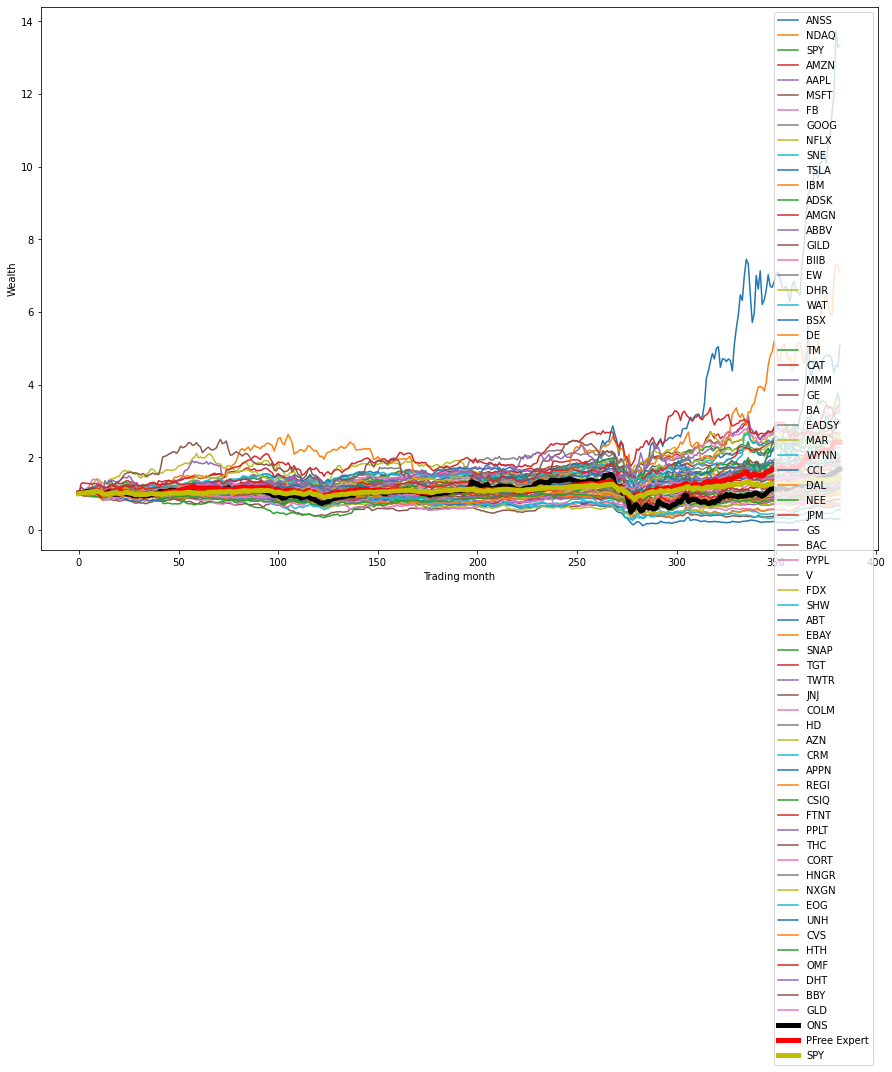

In [ ]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
# ali = times.to_numpy()
# xtimes = [ali[i][2:4]+'/'+ali[i][5:-3] for i in range(len(times))]
for i, symbol in enumerate(my_stocks):
    ax.plot(range(T),np.exp(np.log(stocks[i,:]) - np.log(stocks[i,0])), label=symbol)

ax.plot(range(T), np.exp(log_wealth_ons ), 'k' , linewidth=5, label='ONS')
ax.plot(range(T), np.exp(log_wealth_expert ), 'r' , linewidth=5, label='PFree Expert')
ax.plot(range(T), np.exp(np.log(stocks[2,:])- np.log(stocks[2,0])), 'y' , linewidth=5, label='SPY')

ax.legend()
ax.set_xlabel('Trading month')
ax.set_ylabel('Wealth')
plt.show()
